In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd

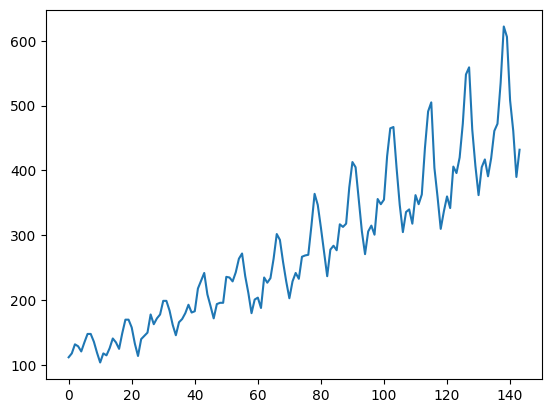

In [41]:
df = pd.read_csv("airline-passengers.csv")
timeseries = df[["Passengers"]].values.astype("float32")

plt.plot(timeseries)
plt.show()

In [42]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_test.shape, y_test.shape)

torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


In [43]:

 class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


C:\Users\niki\AppData\Local\Temp\ipykernel_15960\4122870348.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
C:\Users\niki\AppData\Local\Temp\ipykernel_15960\4122870348.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 225.9200, test RMSE 425.1350
Epoch 100: train RMSE 177.0289, test RMSE 373.8586
Epoch 200: train RMSE 139.8058, test RMSE 333.0642
Epoch 300: train RMSE 109.7735, test RMSE 297.1671
Epoch 400: train RMSE 85.9824, test RMSE 263.7593
Epoch 500: train RMSE 64.2668, test RMSE 229.3800
Epoch 600: train RMSE 50.0443, test RMSE 200.8892
Epoch 700: train RMSE 40.2669, test RMSE 176.5891
Epoch 800: train RMSE 33.6379, test RMSE 155.8282
Epoch 900: train RMSE 28.9901, test RMSE 138.0662
Epoch 1000: train RMSE 25.9953, test RMSE 123.4495
Epoch 1100: train RMSE 23.9324, test RMSE 111.6659
Epoch 1200: train RMSE 23.2957, test RMSE 102.1304
Epoch 1300: train RMSE 22.1414, test RMSE 94.9945
Epoch 1400: train RMSE 21.0019, test RMSE 89.9723
Epoch 1500: train RMSE 20.5791, test RMSE 85.3800
Epoch 1600: train RMSE 20.9293, test RMSE 83.0483
Epoch 1700: train RMSE 19.6908, test RMSE 79.8688
Epoch 1800: train RMSE 19.3713, test RMSE 76.9886
Epoch 1900: train RMSE 19.4145, test RMSE 77.

C:\Users\niki\AppData\Local\Temp\ipykernel_15960\2540086523.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot[lookback:train_size] = y_pred # model(X_train)[:, -1, :]
C:\Users\niki\AppData\Local\Temp\ipykernel_15960\2540086523.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


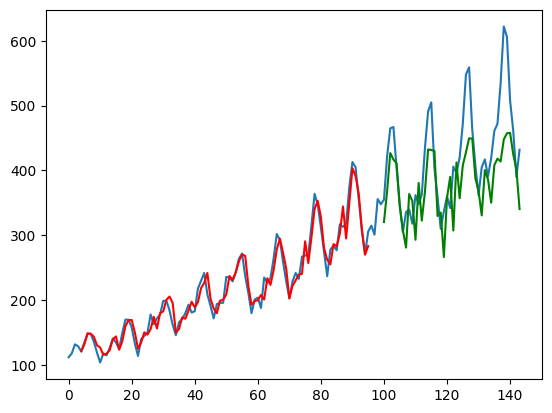

In [44]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = y_pred # model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()